# About this notebook

This notebooks investigates how well a pre-trained `word2vec` model from FastText can capture genre similarities when treating individual genres as words or sentences. The model is tested as is, with no fine-tuning on music related documents.

Each genre, for example `Rock`, is treated as a word and its embedding obtained by the pre-trained model.

Genre similarities are then just the cosine distance between their respective word embeddings.

To investigate how well these embedding similarities reflect musical properties, genre similarities as reported by [`everynoise`](https://everynoise.com) are used for comparison.

This website clusters genres based on musical attributes and thus provides a good baseline.

The methodology of this analysis is as follows:

- Select N most frequently occurring genres based on songs featured on Spotify's curated playlists
- For each pair of these N genres, calculate the cosine distance of `word2vec` embeddings and euclidean distance of `everynoise` embeddings. The latter is effectively based on the `(x, y)` position of the genres in the 2D embedding space.
- For each genre, rank all other genres in terms of decreasing similarity, with the most similar genre assigned the 1st rank and the least similar genre the 100th rank. This creates a ranking for each of the two methods, `word2vec` and `everynoise`.
- Compare the absolute difference in ranking between the two methods. A higher difference suggests that the two methods disagree on a given genre similarity. For example, if `Rock` is the 2nd most similar genre to `Hard Rock` according to `everynoise` but the 50th according to `word2vec`, the two methods for measuring genre similarity lead to different results.
- Assuming that `everynoise` is a faithful representation of genre similarity, we can judge how well `word2vec` performs for the same task by comparing the ranking difference.

As the heatmap in this notebook shows, the rankings of the two methods are frequently quite different, suggesting that `word2vec` is a poor representation of genre similarities.

This is further backed by a one-dimensional ranking of genres and a radial plot.

# Prepare the environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import json
import numpy as np
import fasttext
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
import plotly.express as px
import scipy.stats as stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
import sys
sys.path.append("../")

In [3]:
np.random.seed(2022)

In [4]:
from src.project_config import DATA_DIR, MODEL_DIR
from src.spotify.config import CO_OCCURRENCE_TABLE
from src.spotify.utils import get_frequent_genres

In [5]:
CURATED_DIR = os.path.join(DATA_DIR, "Curated_Playlists")

# Load data

In [6]:
# Pre-trained FastText model
ft = fasttext.load_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))

# Number of genres to include
N = 50

# List of genres by descending order of occurrence
# A) Occurrence based on a user's library
# freq_genres = get_frequent_genres(thr=N)
# B) Occurrence based on Spotify's curated playlists
#    Focus on the top N genres
# freq_genres = pd.read_csv(os.path.join(CURATED_DIR, "curated_playlists_genres.csv")).genre.head(N)
# C) Hand-picked genres
freq_genres = [i.strip() for i in open(os.path.join(DATA_DIR, "manually_picked_genres.txt"), "r").readlines()]
N = len(freq_genres)  # Overwrite N

# Everynoise genre embedding
df = pd.read_csv(os.path.join(DATA_DIR, "genre_space_everynoise.csv"))

# Only analyse frequently occurring genres
df = df.loc[lambda x: x.genre.isin(freq_genres)].copy()

# Sort these genres by their everynoise embedding
# Because those close according to their (x,y) position are musically similar
# This helps keeping similar genres close together in the heatmap at the end of the notebook
# Use everynoise sorting
# df.sort_values(by=["x", "y"], inplace=True)  
# Use custom sorting
order = {v:i for i, v in enumerate(freq_genres)}
df["tmp"] = df.genre.map(order)
df.sort_values(by="tmp", inplace=True)
df.drop(columns=["tmp"], inplace=True)

In [7]:
df.genre.nunique(), df.shape

(23, (23, 3))

In [8]:
# Normalize them to [0, 1]
df["x"] /= df["x"].max()
df["y"] /= df["y"].max()

In [9]:
# Prepare everynoise embedding, i.e. (x,y) position as array
df["everynoise_embedding"] = df.apply(lambda row: np.array([row.x, row.y]), axis=1)
# Get word2vec embedding by treating genre as a sentence 
# because some genres are a composite of several words, like "background music"
df["word2vec_embedding"] = df.genre.apply(ft.get_sentence_vector)
# df.drop(columns=["x", "y"], inplace=True)

In [10]:
# Transform embeddings into a numpy matrix
matrix_everynoise = np.stack(df.everynoise_embedding.values)
matrix_word2vec = np.stack(df.word2vec_embedding.values)

In [11]:
df["genre"] = df["genre"].str.title()

# Calculate genre similarities

In [12]:
# Everynoise embedding similarity based on Euclidean distance
df_everynoise = pd.DataFrame(
    euclidean_distances(matrix_everynoise),
    index=df.genre.values,
    columns=df.genre.values
)
# Distance to similarity
df_everynoise.loc[:] = 1 / (1 + df_everynoise.values)

# Word2vec embedding similarity based on Cosine similarity
df_word2vec = pd.DataFrame(
    cosine_similarity(matrix_word2vec),
    index=df.genre.values,
    columns=df.genre.values
)

In [13]:
df_everynoise.iloc[:5, :5]

Pop   Europop     K-Pop   Hip Pop   Hip Hop
Pop      1.000000  0.928057  0.962072  0.864095  0.812028
Europop  0.928057  1.000000  0.905024  0.836687  0.776721
K-Pop    0.962072  0.905024  1.000000  0.844428  0.803143
Hip Pop  0.864095  0.836687  0.844428  1.000000  0.905089
Hip Hop  0.812028  0.776721  0.803143  0.905089  1.000000

In [14]:
df_word2vec.iloc[:5, :5]

Pop   Europop     K-Pop   Hip Pop   Hip Hop
Pop      1.000000  0.478847  0.400268  0.811203  0.413060
Europop  0.478847  1.000000  0.431301  0.453001  0.313068
K-Pop    0.400268  0.431301  1.000000  0.373133  0.233740
Hip Pop  0.811203  0.453001  0.373133  1.000000  0.777631
Hip Hop  0.413060  0.313068  0.233740  0.777631  1.000000

In [15]:
# Transform distance matrix into a ranking matrix:
# Given a genre, the closest genre to it will be given rank equal to 1
# and the genre most different a rank equal to N

df_everynoise_ranked = pd.DataFrame(
    np.apply_along_axis(stats.rankdata, arr=-1 * df_everynoise.values, axis=1),
    index=df_everynoise.index,
    columns=df_everynoise.columns
).astype(int)

df_word2vec_ranked = pd.DataFrame(
    np.apply_along_axis(stats.rankdata, arr=-1 * df_word2vec.values, axis=1),
    index=df_word2vec.index,
    columns=df_word2vec.columns
).astype(int)

In [16]:
df_everynoise_ranked.iloc[:5, :5]

Pop  Europop  K-Pop  Hip Pop  Hip Hop
Pop        1        4      3        8       13
Europop    3        1      5        9       13
K-Pop      2        4      1        7       12
Hip Pop   10       13     12        1        6
Hip Hop    8       13     10        5        1

In [17]:
df_word2vec_ranked.iloc[:5, :5]

Pop  Europop  K-Pop  Hip Pop  Hip Hop
Pop        1        4     10        2        9
Europop    3        1      6        4       13
K-Pop      4        3      1        5       12
Hip Pop    2        8     11        1        3
Hip Hop    5        8     17        3        1

Note that entries in the diagonals are equal to 1 because distance between the two genres is 0.

The lower the ranking, the more similar the two genres are.

The highest ranking is equal to 100 because we have only inlcuded 100 genres in this analysis.

Looking at the second table (`word2vec`) we see that white noise is not similar to the genre metalcore at all (rank 88).

There are other 87 genres that are more similar to white noise than metalcore is.

In fact, background music is the most similar genre (rank 2).

# Visualise word2vec vs everynoise genre similarities

## t-SNE

First, let's project word2vec genre embeddings onto a 2D space and see if genres cluster similarly across the two approaches. Note that Every Noise embeddings are already in a 2D space.

In [18]:
x = df.everynoise_embedding.apply(lambda x: x[0]).values
y = df.everynoise_embedding.apply(lambda x: x[1]).values

In [19]:
# Manually move the location of some genres by a small amount to ensure that the
# labels in the plot do not end up overlapping
y_alt = y.copy()
for g, idx in zip(df.genre, range(y.shape[0])):
    if g == "Edm":
        y_alt[idx] -= 0.05
    elif g == "Tropical House":
        y_alt[idx] -= 0.1
    elif g == "House":
        y_alt[idx] -= 0.05
    elif g == "Grime":
        y_alt[idx] += 0.05

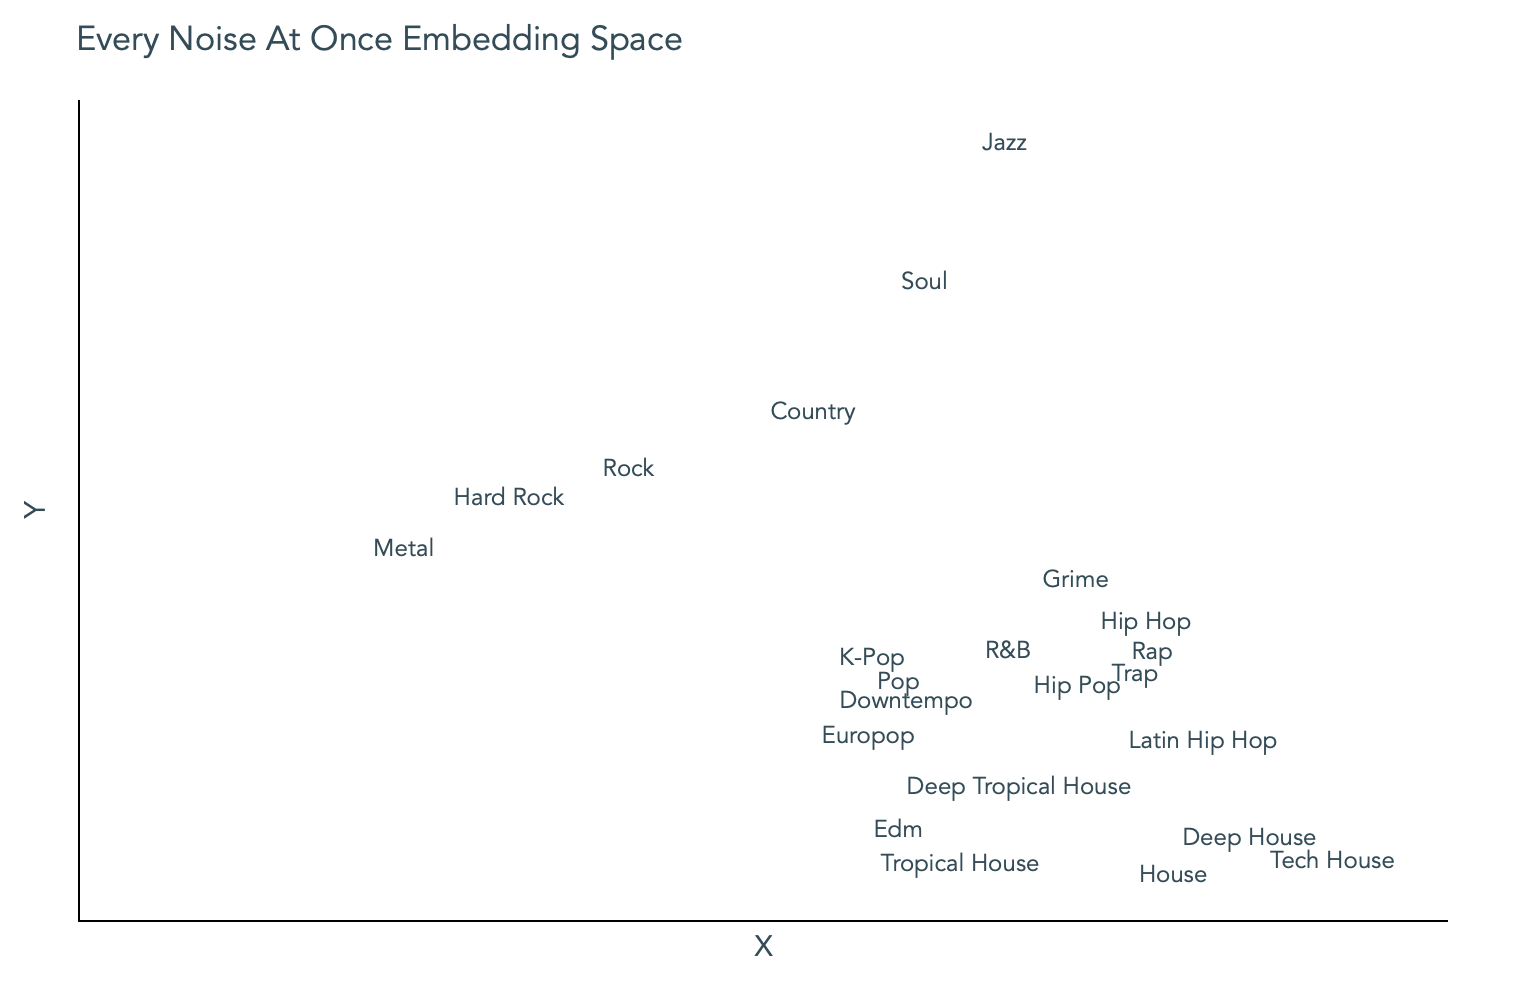

In [20]:
fig = px.scatter(
    x=x, 
    y=y_alt, 
    text=df.genre.str.title(), size=np.zeros(len(df)),
    width=1200,
    height=1000,
    title="Every Noise At Once Embedding Space"
)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', 
                  xaxis=dict(showticklabels=False), 
                  yaxis=dict(showticklabels=False), 
                  xaxis_title="X", 
                  yaxis_title="Y",
                  font=dict(
                    family="avenir, sans serif",
                    size=24,
                    color="#334c57"
                  )
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', range=[-0.1, 1.1])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig

In [21]:
tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=5, random_state=2022)
word2vec_tsne_2D = tsne.fit_transform(np.stack(df.word2vec_embedding.values))

In [22]:
x = word2vec_tsne_2D[:, 0]
y = word2vec_tsne_2D[:, 1]

In [23]:
# Manually move the location of some genres by a small amount to ensure that the
# labels in the plot do not end up overlapping
y_alt = y.copy()
for g, idx in zip(df.genre, range(y.shape[0])):
    if g == "Hip Hop":
        y_alt[idx] += 0.8
    elif g == "Deep House":
        y_alt[idx] -= 1.2

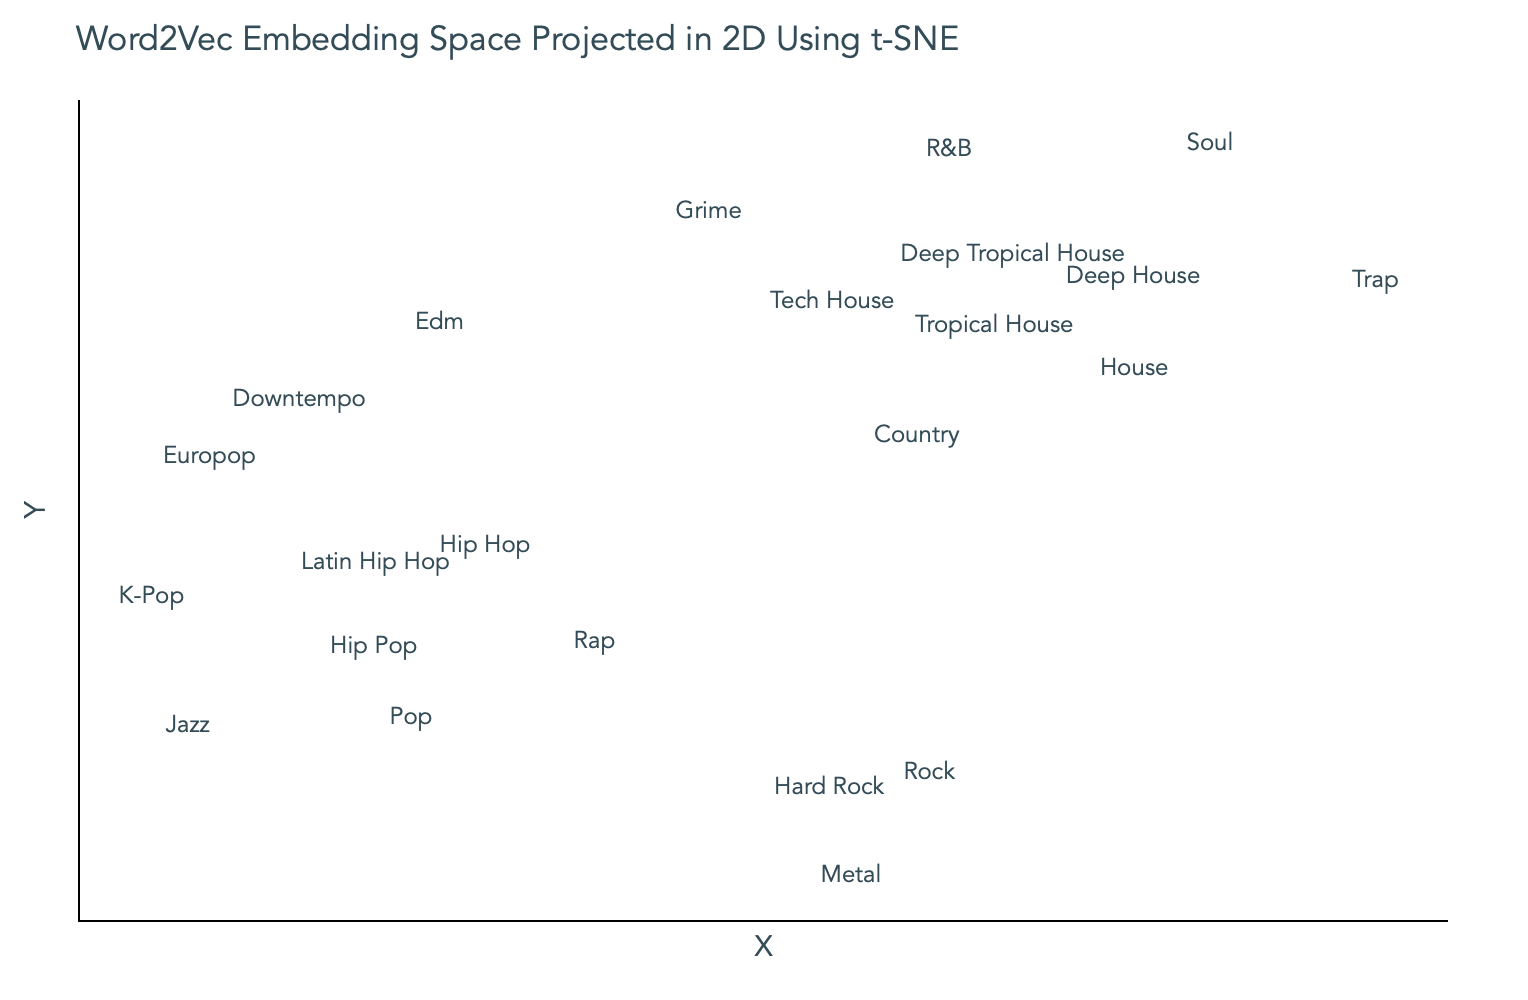

In [24]:
fig = px.scatter(
    x=x, 
    y=y_alt, 
    text=df.genre.str.title(), 
    size=np.zeros(len(df)),
    width=1200,
    height=1000,
    title="Word2Vec Embedding Space Projected in 2D Using t-SNE"
)
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)', 
    xaxis=dict(showticklabels=False), 
    yaxis=dict(showticklabels=False), 
    xaxis_title="X", 
    yaxis_title="Y",
    font=dict(
        family="avenir, sans serif",
        size=24,
        color="#334c57"
    )
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig

## Comparison of a single genre

In [25]:
chosen_genre = "Rap"

In [26]:
# Similarities
subset_everynoise = df_everynoise.loc[chosen_genre, df_everynoise.columns.difference([chosen_genre])]
subset_word2vec = df_word2vec.loc[chosen_genre, df_word2vec.columns.difference([chosen_genre])]

# Rankings
subset_everynoise_ranked = df_everynoise_ranked.loc[chosen_genre, df_everynoise_ranked.columns.difference([chosen_genre])] - 1
subset_word2vec_ranked = df_word2vec_ranked.loc[chosen_genre, df_word2vec_ranked.columns.difference([chosen_genre])] - 1

In [27]:
parts = [
    subset_everynoise.to_frame().rename(columns={chosen_genre: "EveryNoise"}),
    subset_word2vec.to_frame().rename(columns={chosen_genre: "Word2Vec"}),
    subset_everynoise_ranked.to_frame().rename(columns={chosen_genre: "EveryNoise_rank"}),
    subset_word2vec_ranked.to_frame().rename(columns={chosen_genre: "Word2Vec_rank"})
]

In [28]:
to_visualise = reduce(lambda a, b: pd.merge(a, b, left_index=True, right_index=True), parts)

In [29]:
for c in to_visualise.columns:
    if not c.endswith("_rank"):
        to_visualise[c+"_score"] = MinMaxScaler().fit_transform(to_visualise[c].values.reshape(-1, 1))

In [30]:
to_visualise["label"] = (
    to_visualise.index.str.title().map(lambda x: x.replace(" ", "<br>"))  + "<br><br>" 
    + "ENO: " + to_visualise.EveryNoise_rank.astype(int).astype(str) + "<br>" 
    + "W2V: " + to_visualise.Word2Vec_rank.astype(int).astype(str)
)

In [31]:
to_visualise.sort_values(by="EveryNoise_rank", inplace=True, ascending=False)

In [32]:
# Adding co-occurrence similarities as an additional reference
co_occurrence_lookup = pd.read_csv(
    CO_OCCURRENCE_TABLE,
    index_col=[0, 1]
)
co_occurrence_lookup.columns = ["CoOccurrenceValue"]

mask = co_occurrence_lookup.index.get_level_values(0) == chosen_genre.lower()
mask |= co_occurrence_lookup.index.get_level_values(1) == chosen_genre.lower()

df_co_occurrence = co_occurrence_lookup.loc[mask].reset_index()

levels = [i for i in df_co_occurrence if "level" in i]
df_co_occurrence["genre"] = df_co_occurrence[levels].apply(lambda row: "".join([i for i in row if i != chosen_genre.lower()]), axis=1)
df_co_occurrence.drop(columns=levels, inplace=True)
df_co_occurrence["genre"] = df_co_occurrence["genre"].str.title()
df_co_occurrence = df_co_occurrence.loc[df_co_occurrence.genre.isin(to_visualise.index)].copy()
df_co_occurrence["similarity"] = MinMaxScaler().fit_transform(df_co_occurrence.CoOccurrenceValue.values.reshape(-1, 1))
mapping_genre_co_occurrence = df_co_occurrence.set_index("genre")["similarity"].to_dict()
to_visualise["Co_Occurrence_score"] = to_visualise.index.map(mapping_genre_co_occurrence).fillna(0)

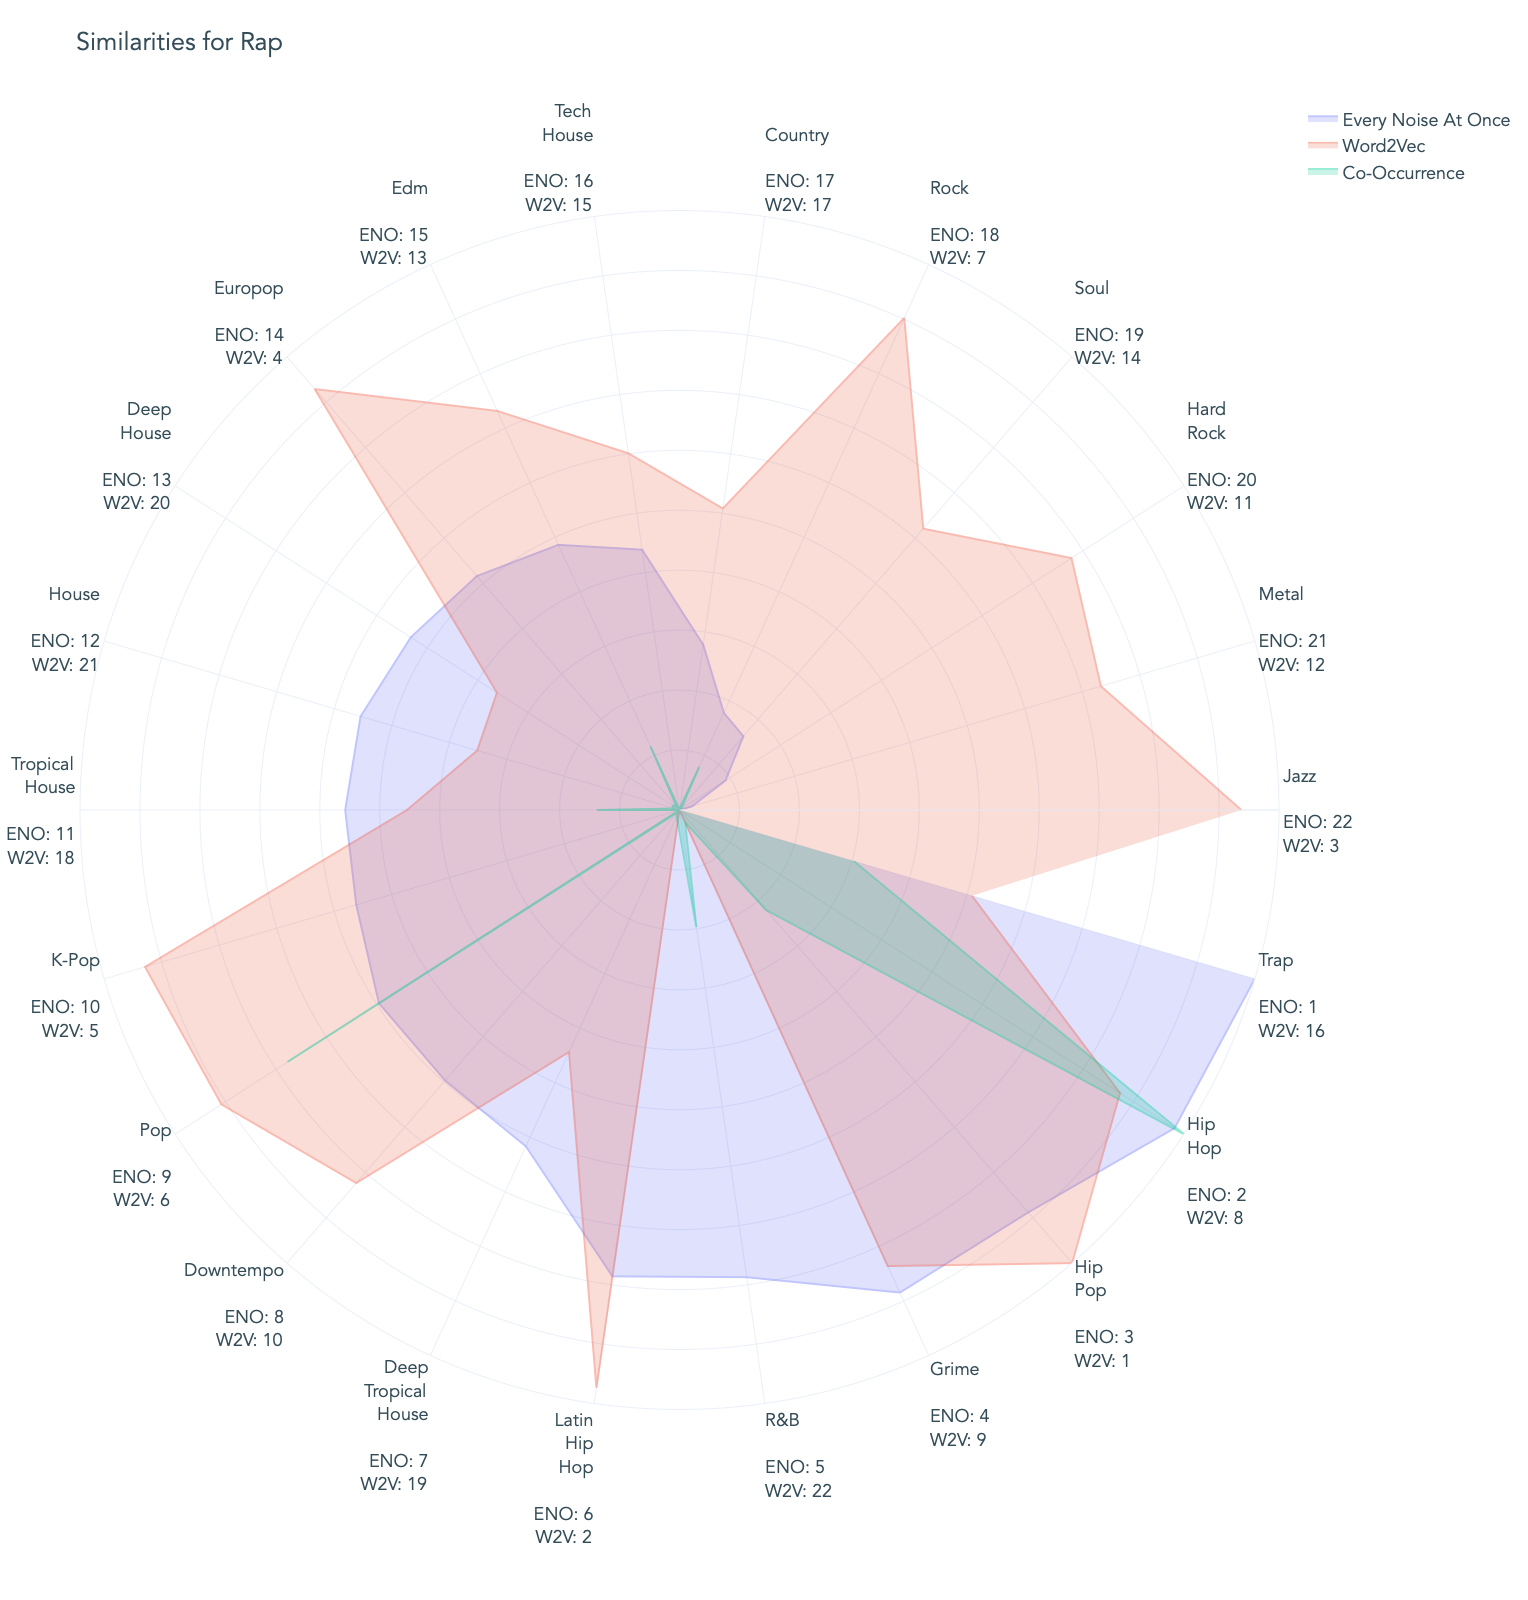

In [33]:
fig = make_subplots(
    rows=1, cols=1,
    specs=[[
        {'type': 'polar'}
    ]],
    column_widths=[1]
)
fig.add_trace(
    go.Scatterpolar(
        r=to_visualise.EveryNoise_score,
        theta=to_visualise.label,
        name="Every Noise At Once",
        fill="toself",
        opacity=0.4
    ), 
    row=1, col=1
)
fig.add_trace(
    go.Scatterpolar(
        r=to_visualise.Word2Vec_score,
        theta=to_visualise.label,
        name="Word2Vec",
        fill="toself",
        opacity=0.4
    ), 
    row=1, col=1
)
fig.add_trace(
    go.Scatterpolar(
        r=to_visualise.Co_Occurrence_score,
        theta=to_visualise.label,
        name="Co-Occurrence",
        fill="toself",
        opacity=0.4
    ), 
    row=1, col=1
)
fig.update_layout(
    template="plotly_white",
    title=f"Similarities for {chosen_genre.title()}",
    plot_bgcolor='rgb(255,255,255)',
    polar=dict(
        radialaxis=dict(showticklabels=False, ticks=''),
    ),
    height=1600,
    width=1400,
    font=dict(
        family="avenir, sans serif",
        size=18,
        color="#334c57"
    )
)

**How to read the graph**: For a selected genre (here `Rap`) the graph visualises the similarity metrics obtained under the two approaches.
Similarity metrics have been scaled to fall in the range of [0, 1], such that the most similar genre to the selected one has a similarity value of 1.
Note that since the two approaches use different formulas to obtain similarities (cosine vs euclidean), the distributions are different.
Specifically, Word2Vec generally attributes higher similarities to genre pairs. So the difference between a more similar and a less similar genre are not as pronounced as for Every Noise At Once. The tick labels provide the associated similarity ranking of a given genre, for both approaches. For example, for Every Noise at Once (ENO), Trap is the most similar genre to rap of the considered genres. Therefore, its rank is 1.

**Interpretation**: The two approaches agree on the similarity of genres only in a few instances.For example, both consider `Rap` as being failry similar to `Hip Pop`, `Hip Hop` and `Lating Hip Hop`. However, W2V considers `Jazz` to be the 3rd most similar genre to `Rap` out of all the selected genres, which is difficult to subjectively support. Also, ENO correctly identifies the similarities between `Rap` and `Trap`, which is not captured by W2V at all.

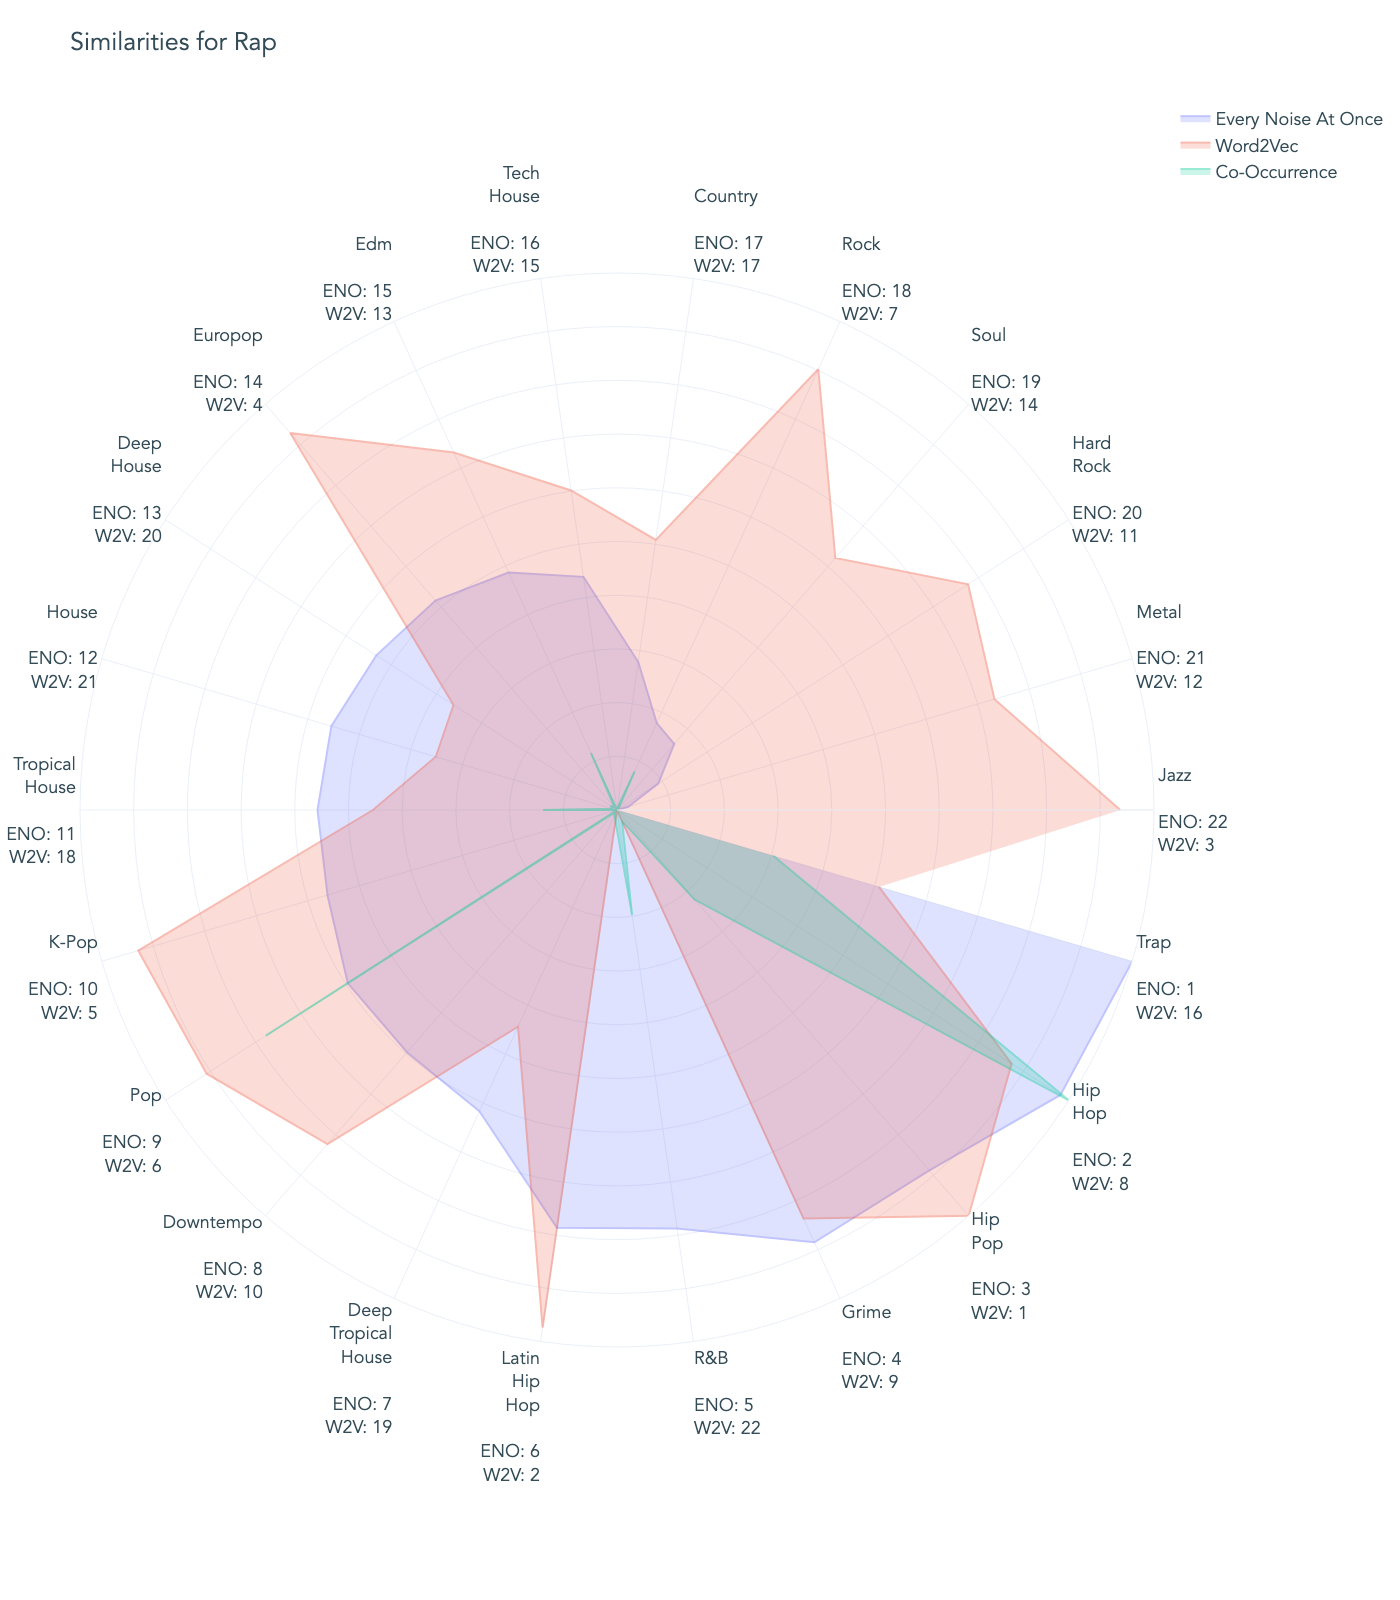

In [34]:
# For Github: visualise a static version of the above Plotly figure
from IPython.display import Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## Comparison of all genres

Based on the concept of comparing the ranking of genres by similarity under both approaches. Let's create a visualisation that summarises similarities across all genres at once. To this end, we will plot a matrix, with each cell corresponding to a pair of genres, i.e. $M_{ij} = (g_i, g_j)$ which takes on as values the difference in similarity ranking, i.e. $\text{Ranking}_{W2V}(g_i) - \text{Ranking}_{ENO}(g_i)$

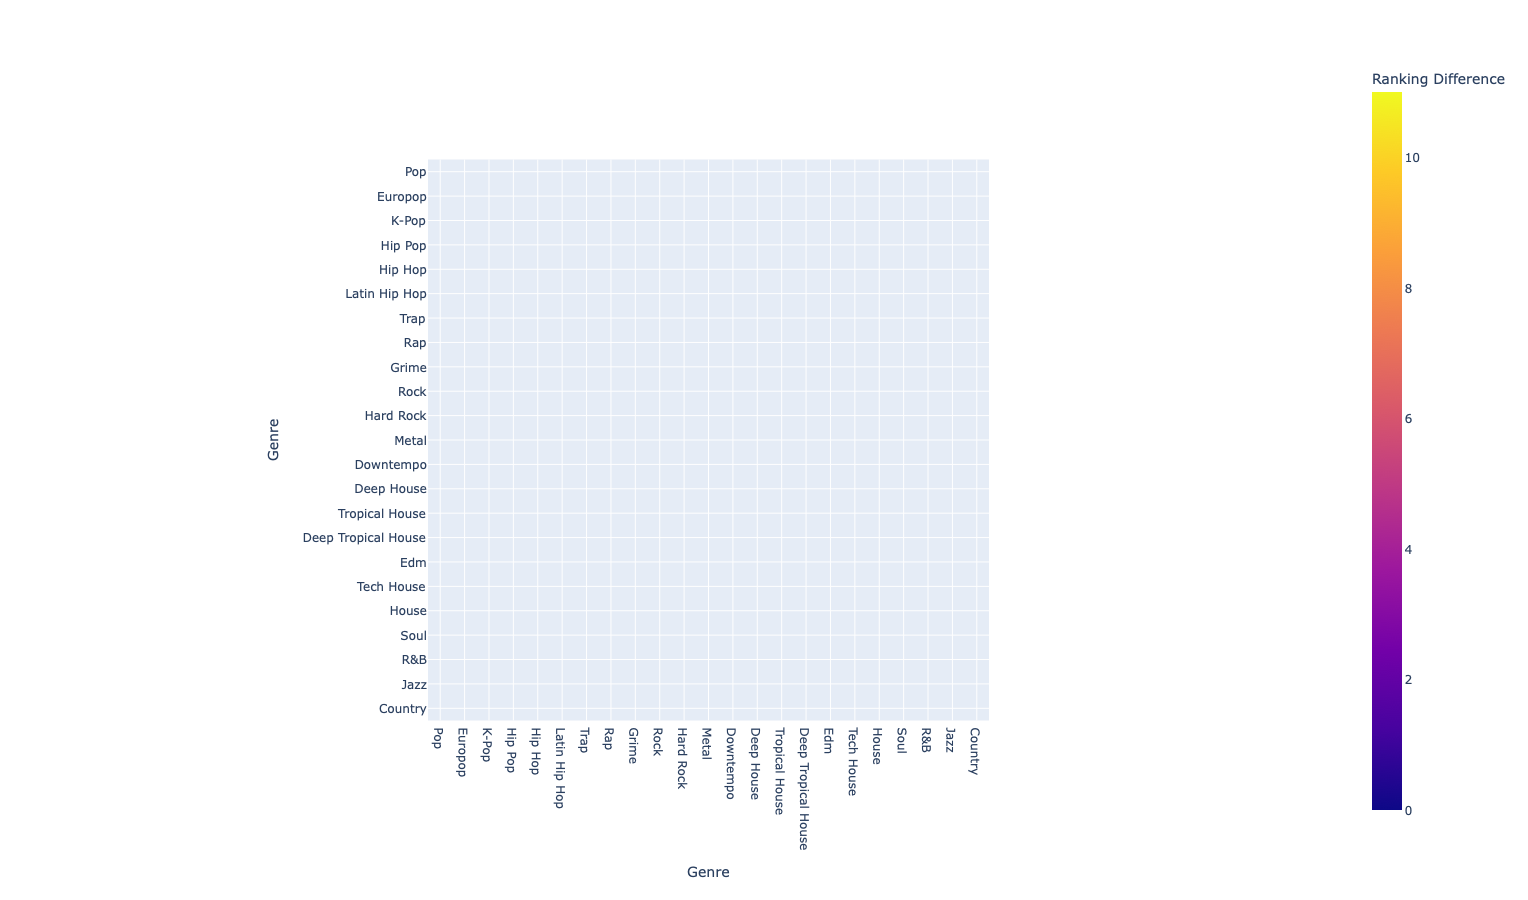

In [35]:
# https://plotly.com/python/annotated-heatmap/
fig = px.imshow(
    (df_word2vec_ranked - df_everynoise_ranked).abs(),
    labels=dict(x="Genre", y="Genre", color="Ranking Difference"),
    width=900,
    height=900,
    zmax=N // 2  # Saturate graph above this value because two methods really disagree on genre similaritya
)
fig.update_traces(
    customdata=np.moveaxis([df_word2vec_ranked, df_everynoise_ranked.astype(int)], 0, -1), 
    hovertemplate="""
    <b>Genre pair:</b> %{x} – %{y}<br>
    <b>Ranking Difference:</b> %{z}<br>
    <b>Ranking Word2Vec vs Everynoise:</b> %{customdata[0]} vs %{customdata[1]}<br>
    """
)
fig.show()

**How to read the graph**: Every cell's colour represents the difference in W2V and ENO rankings for a specific genre pair, which is defined by the y-axis and x-axis ticks. The more W2V and ENO dissagree on the similarity of a specific genre pair, the brighter the colour.

**Interpretation**: Looking at the graph we see that W2V and ENO do not really agree on genre similarities across the board. For `Rap`, we find back the differences from the previous radial plot, specifically pronounced for `Trap` and `Jazz`. In general, we see that `R&B` and `Jazz` are really much treated differently by W2V and ENO.

**Conclusion**: `word2vec` leads to genre similarities that are quite different to those obtained from `everynoise`, which one can treat as capturing genre similarities rather well. Therefore, using a pre-trained `word2vec` model without fine-tuning is not a very good approach to measuring genre similarities.

In [ ]:
# For Github: visualise a static version of the above Plotly figure
from IPython.display import Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)